# Tabling fast

This is the script to create the table of measurements in section 4.

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, NonlinearConstraint
import scipy.constants as c
import matplotlib.transforms as mtransforms
import os
from pyphonon import *

# Check for GPU support
try:
    import cupy as cp
    import numpy as np
    GPU = True
    print(bcolors.OKGREEN+'GPU Support Enabled'+bcolors.ENDC)
except ImportError:
    import numpy as np
    GPU = False
    print(bcolors.WARNING+'Cupy Not available in your system. No GPU Support'+bcolors.ENDC)

# Ignore large warnings
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# Set some flags and environment variables
data_dir     = './data/'
fluid_dir    = 'fluids/'
particle_dir = 'particles/'

%matplotlib widget

CUDA GPU Acceleration is unavailable for your system : (
Cupy Not available in your system. No GPU Support


In [2]:
# Collect the fluids and particles from the directories
fluid_files     = [data_dir+fluid_dir+f for f in os.listdir(data_dir+fluid_dir)]
fluid_names     = [f.replace('.txt','') for f in os.listdir(data_dir+fluid_dir)]
particle_files  = [data_dir+particle_dir+f for f in os.listdir(data_dir+particle_dir)]
particle_names  = [f.replace('.txt','') for f in os.listdir(data_dir+particle_dir)]
fluids          = [fluid(fname,name=n) for fname,n in zip(fluid_files,fluid_names)] 
particles       = [particle(fname,name=n) for fname,n in zip(particle_files,particle_names)]

In [3]:
# Create an estimator

# Simulator parameters
max_order   = 0
n_cores     = 20
slow        = False

# Create estimator
E = estimator(max_order=max_order,n_cores=n_cores,slow=slow,GPU=GPU)

Generating Estimator for order 0
Assembling the estimator using multiprocessing on 20 cores
Permuations created successfully
	Send the fast data to the pool
CUDA GPU Acceleration is unavailable for your system : (
	Fast: 0, 0 Done!
Pool closed Successfully
recasting functions


  0%|          | 0/1 [00:00<?, ?it/s]

Estimator Generated Successfully


In [4]:
# Create a better estimator

# Simulator parameters
max_order   = 1
n_cores     = 20
slow        = False

# Create estimator
G = estimator(max_order=max_order,n_cores=n_cores,slow=slow,GPU=GPU)

Generating Estimator for order 1
Assembling the estimator using multiprocessing on 20 cores
Permuations created successfully
	Send the fast data to the pool
CUDA GPU Acceleration is unavailable for your system : (
CUDA GPU Acceleration is unavailable for your system : (
CUDA GPU Acceleration is unavailable for your system : (
	Fast: 0, 0 Done!


In [ ]:
#### HELPER FUNCTIONS #####

# Get the values for multiple fluids
def max_pressure_fluids(r,v,fluids,particle,E=E,G=G):
    # Set the particle's velocity
    particle(v)

    # Arrays to store stuff
    fmax    = []
    pres    = []
    results = []
    
    # For each fluid
    for fluid in tqdm(fluids):
        # Get viscosity coefficient
        l = fluid.viscosity_coefficient()*fluid.sound_speed
        V = particle.speed/fluid.sound_speed

        # Find the maximum at zero order
        fun,x,res = max_pressure(r,V,l,E=E)

        # Plug it in to the corrected order
        fmax.append(G(r,x[1],x[0],V,l))
        results.append(res)
        pres.append(-fmax[-1]*fluid.energy_deposition(particle))

        # Print some stuff
        print(fluid.name + ': %.15e %.15e %.15e Pa'%(fun,fmax[-1],pres[-1]))


    return fmax,pres,results



# Calculate the maximum pressure given certain parameters
def max_pressure(r,v,l,E=E):
    # Initial token z position
    z   = 0.1

    # Estimator caller
    p = lambda x: -E(r,x[1],x[0],v,l)

    # Do the optimization
    x0 = np.array([np.sqrt(r**2 + z**2),0])
    res = minimize(p,x0,method='nelder-mead', options={'xatol': 1e-9, 'disp': True})

    return -res['fun'], res['x'], res

# Calculate the maximum pressure given certain parameters and constraints
def max_pressure_constrained(r,v,l,JAC=None,HES=None,E=E):
    # Initial token z position
    z   = 0.1

    # Define constraints
    const   = lambda x: np.array(x[0] - np.sqrt(r**2 + x[1]**2))
    cjac    = lambda x: np.array([1,-x[1]/np.sqrt(r**2 + x[1]**2)])
    chess   = lambda x,v: v[0]*np.array([[0,0],[0,-r**2/np.sqrt(r**2+x[1]**2)**3]])
    
    constraint = NonlinearConstraint(const,0,np.inf,jac=cjac,hess=chess)

    # Get jacobian and hessian estimator
    if JAC is None:
        print('Generating Jacobian')
        JAC     = E.get_jacobian()
    if HES is None:
        print('Generating Hessian')
        HES     = E.get_hessian()

    # Jacobian and Hessian converters
    jac = lambda x: JAC(r,x[1],x[0],v,l)
    hes = lambda x: HES(r,x[1],x[0],v,l)

    # Estimator caller
    p = lambda x: -E(r,x[1],x[0],v,l)

    # Do the optimization
    print('Starting Optimization')
    x0 = np.array([np.sqrt(r**2 + z**2)+0.0001,0])
    res = minimize(p,x0,method='trust-constr', #jac=jac, hess=hes, 
                    constraints=[constraint], options={'verbose': 1, 'disp': True})

    return -res['fun'], res['x'], res

# Plot the maximum
def plot_max(r,z,t,v,l,E=E,tol=0.01,Npts=10000,fig=None,ax=None,Extras=True,T=None,T_scaled=None,mult=1,label=None):
    # Create a figure
    if fig is None: fig = plt.figure()
    if ax is None:  ax  = fig.add_subplot(111)
    trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)

    # Get the time and plot everything
    if T is None: T   = np.linspace(t-tol,t+tol,Npts)
    if T_scaled is None: T_scaled = T
    ax.plot(T_scaled,mult*E(r,z,T,v,l),label=label)
    if Extras: 
        ax.axvline(t,c='k')
        ax.fill_between(T,0,1,v*T - (z+r*np.sqrt(v**2-1)) < 0,facecolor='red',alpha=0.1,transform=trans)

    return fig,ax

49999999.99999999 0.16666666666666663
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 148
         Function evaluations: 308
 final_simplex: (array([[1.40777338e+03, 7.79641716e-03],
       [1.40777338e+03, 7.79641748e-03],
       [1.40777338e+03, 7.79641784e-03]]), array([-2.68371813e-13, -2.68371813e-13, -2.68371813e-13]))
           fun: -2.6837181329063586e-13
       message: 'Optimization terminated successfully.'
          nfev: 308
           nit: 148
        status: 0
       success: True
             x: array([1.40777338e+03, 7.79641716e-03])


2.683724701784725e-13

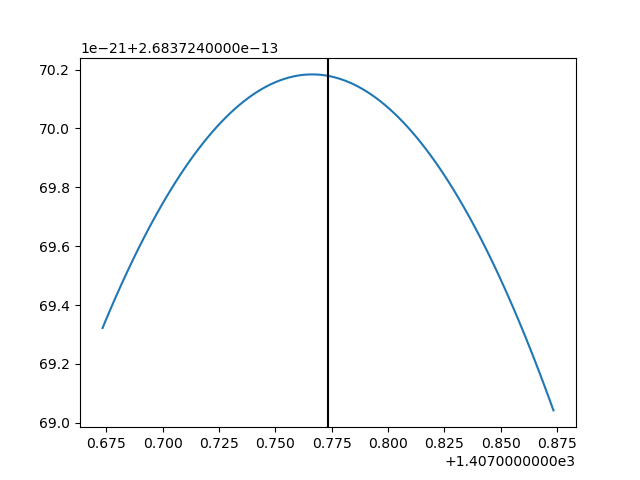

In [ ]:
muon    = particles[0]
xe      = fluids[3]

muon(250000*xe.sound_speed)
muon(0.5e8)
r = 1e-3
v = muon.speed/xe.sound_speed
l = xe.viscosity_coefficient()*xe.sound_speed
print(v*xe.sound_speed,v*xe.sound_speed/3e8)

fun,x,res = max_pressure(r,v,l)
print(res)
fig,ax = plot_max(r,x[1],x[0],v,l,tol=.1,Npts=100,E=G)
G(r,x[1],x[0],v,l)

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

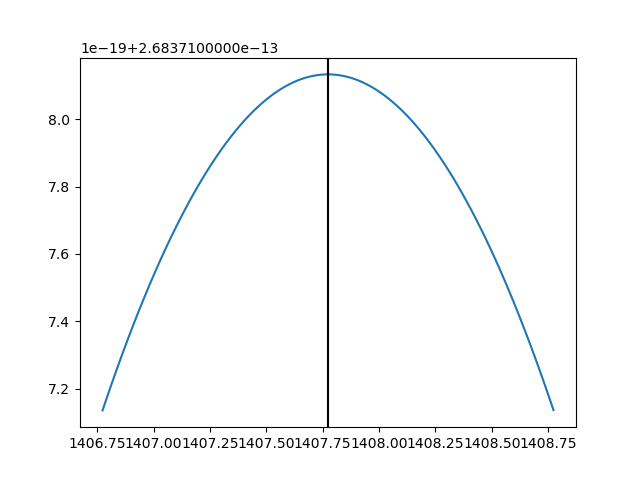

In [ ]:
plot_max(r,x[1],x[0],v,l,tol=1,Npts=100)

In [ ]:
# Calculate the table

# Pick a velocity
r = 1e-2
v = 0.5*c.c #200*xe.sound_speed/xe.sound_speed

# Calculate the table
fmax, pressure, results = max_pressure_fluids(r,v,fluids,particles[0],E=E,G=G)

  0%|          | 0/6 [00:00<?, ?it/s]

Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 165
         Function evaluations: 330
LKR: 1.171516771524769e-14 1.171516854780283e-14 6.077423134741997e-24 Pa
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 152
         Function evaluations: 315
LXE2: 9.627134766457319e-15 9.627135474074996e-15 5.305747831059868e-24 Pa
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 149
         Function evaluations: 303
LAR: 2.104221679381598e-14 2.104221810060779e-14 8.974572512132600e-24 Pa
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 42
         Function evaluations: 116
LXE: 4.743384504624082e-19 1.561494368917621e-06 8.248893953733384e-16 Pa
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 147
         Function evaluations: 303

In [ ]:
particles[0](v)
for i in range(6):
    print(fluids[i].name,fluids[i].max_energy(particles[0]))

LKR 2.6340027782191275
LXE2 2.4038278605141397
LAR 3.012864510226083
LXE 3.7143795253159757
LNE 3.467369953708237
LHG 2.1533312175320605


(0.0, 34.48038066340253)

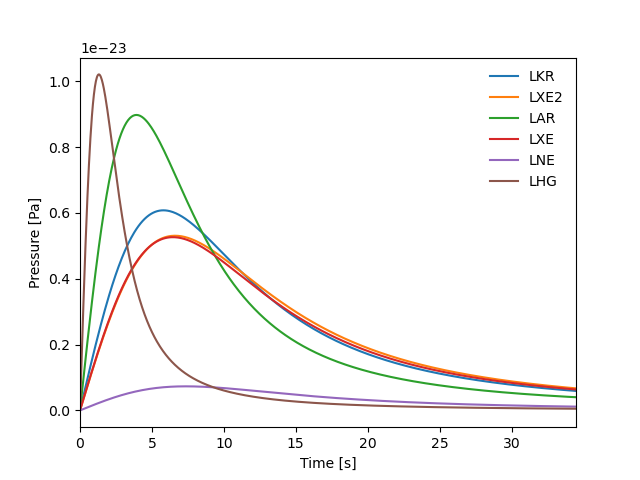

In [ ]:
# Finally plot the maxima for the various values
P = particles[0]
fig = plt.figure()
ax  = fig.add_subplot(111)
Npts = 1000
M_max = 50000
T   = np.linspace(0,M_max,Npts)
M_max = np.inf

for res,f in zip(results,fluids):
    # Get viscosity coefficient
    l           = f.viscosity_coefficient()*f.sound_speed
    V           = P.speed/f.sound_speed
    T_scaled    = T/f.sound_speed
    M_max = min(M_max,T_scaled[-1])
    plot_max(r,res['x'][1],res['x'][0],V,l,E=E,fig=fig,ax=ax,Extras=False,
                T=T,T_scaled=T_scaled,mult=-f.energy_deposition(P),label=f.name)

ax.legend(frameon=False)
ax.set_ylabel('Pressure [Pa]')
ax.set_xlabel('Time [s]')
ax.set_xlim(0,M_max)